## [Langfuse Prompt Management with Langchain](https://langfuse.com/guides/cookbook/prompt_management_langchain)

### Setup

In [ ]:
%pip install langfuse langchain langchain-openai --upgrade

In [1]:
import os
import base64


# Get keys for your project from the project settings page: https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = "pk-lf-962190cc-b2bd-47c0-b752-8de287a2a5c1"
os.environ["LANGFUSE_SECRET_KEY"] = "sk-lf-4e9959c3-0935-4142-b789-734beb81d15a"
os.environ["LANGFUSE_HOST"] = "http://localhost:3000"

# Your openai key
# os.environ["OPEN_AI_URL"] = "https://open.bigmodel.cn/api/paas/v4/"
os.environ["OPENAI_API_KEY"] = "f0c1fb9f5c534e55a66d9e539916fdb0.GQKa6HaX6MpT9ioJ"
os.environ["OPENAI_BASE_URL"] = "https://open.bigmodel.cn/api/paas/v4"

In [2]:
from langfuse import get_client
from langfuse.langchain import CallbackHandler
 
# Initialize Langfuse client (prompt management)
langfuse = get_client()
 
# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_callback_handler = CallbackHandler()

### Add prompt to Langfuse Prompt Management

We add the prompt used in this example via the SDK. Alternatively, you can also edit and version the prompt in the Langfuse UI.

* Name that identifies the prompt in Langfuse Prompt Management

* Prompt with prompt template incl. {{input variables}}

* Config including model_name and temperature

* labels to include production to immediately use prompt as the default

In [3]:
langfuse.create_prompt(
    name="event-planner",
    prompt=
    "Plan an event titled {{Event Name}}. The event will be about: {{Event Description}}. "
    "The event will be held in {{Location}} on {{Date}}. "
    "Consider the following factors: audience, budget, venue, catering options, and entertainment. "
    "Provide a detailed plan including potential vendors and logistics.",
    config={
        "model":"glm-4.5-flash",
        "temperature": 0,
    },
    labels=["production"]
);

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/prompts/event-planner?tab=prompt)

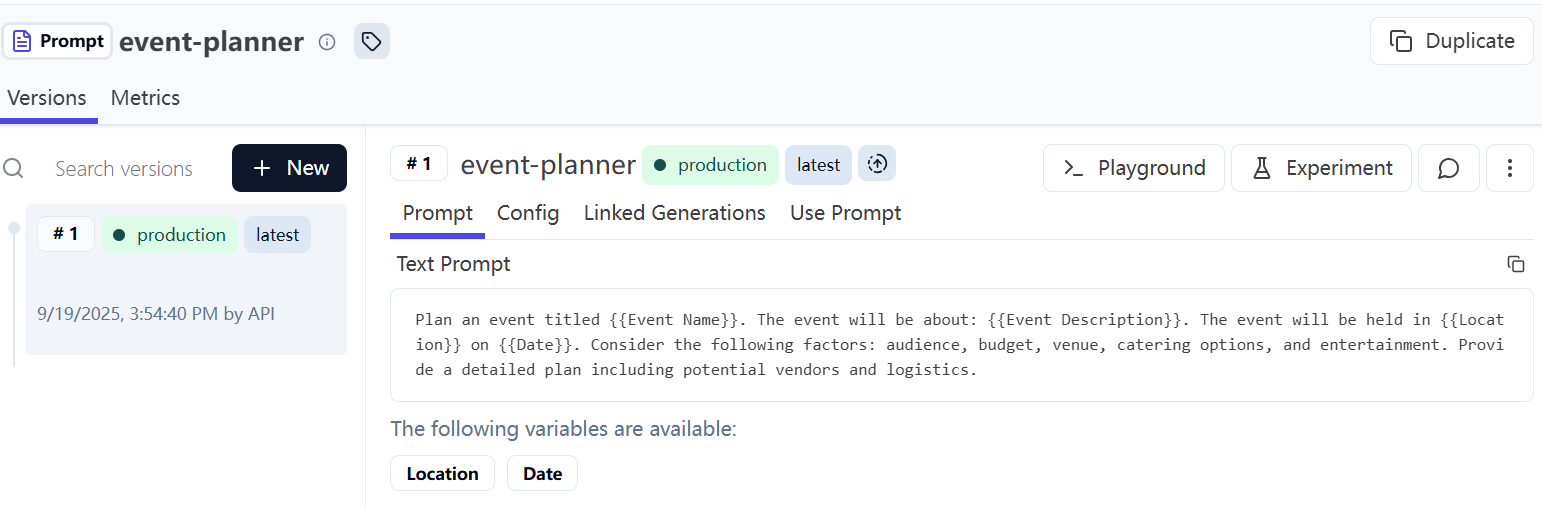

### Get current prompt version from Langfuse

In [3]:
# Get current production version of prompt
langfuse_prompt = langfuse.get_prompt("event-planner")

In [4]:
print(langfuse_prompt.prompt)

Plan an event titled {{Event Name}}. The event will be about: {{Event Description}}. The event will be held in {{Location}} on {{Date}}. Consider the following factors: audience, budget, venue, catering options, and entertainment. Provide a detailed plan including potential vendors and logistics.


### Transform into Langchain PromptTemplate

Use the utility method .get_langchain_prompt() to transform the Langfuse prompt into a string that can be used in Langchain.

Context: Langfuse declares input variables in prompt templates using double brackets ({{input variable}}). Langchain uses single brackets for declaring input variables in PromptTemplates ({input variable}). The utility method .get_langchain_prompt() replaces the double brackets with single brackets.

Also, pass the Langfuse prompt as metadata to the PromptTemplate to automatically link generations that use the prompt.

In [6]:
from langchain_core.prompts import ChatPromptTemplate

langchain_prompt = ChatPromptTemplate.from_template(
    langfuse_prompt.get_langchain_prompt(),
    metadata={"langfuse_prompt": langfuse_prompt},
)

In [7]:
model = langfuse_prompt.config["model"]
temperature = str(langfuse_prompt.config.get("temperature", 0))

print(f"Prompt model configurations\nModel: {model}\nTemperature: {temperature}")

Prompt model configurations
Model: glm-4.5-flash
Temperature: 0


### Create Langchain chain based on prompt

In [8]:
from langchain_openai import ChatOpenAI

chat_model = ChatOpenAI(
        model=model,
        temperature=temperature,
    )

chain = langchain_prompt | chat_model

### Invoke chain

In [10]:
example_input = {
    "Event Name": "Wedding",
    "Event Description": "The wedding of Julia and Alex, a charming couple who share a love for art and nature. This special day will celebrate their journey together with a blend of traditional and contemporary elements, reflecting their unique personalities.",
    "Location": "Central Park, New York City",
    "Date": "June 5, 2024"
}

In [ ]:
# we pass the callback handler to the chain to trace the run in Langfuse
response = chain.invoke(input=example_input,config={"callbacks":[langfuse_callback_handler]})
 
print(response.content)


### Event Plan: **Central Park Eco-Fest**  
**Event Description:** A family-friendly celebration of sustainability, featuring eco-friendly vendors, educational workshops, live music, and activities promoting environmental awareness.  

---

### **1. Audience**  
- **Primary:** Families, eco-conscious millennials, students, local residents, and tourists.  
- **Secondary:** Environmental NGOs, corporate sponsors, and community groups.  
- **Attendance Goal:** 500–800 attendees.  

---

### **2. Budget**  
**Total Budget:** $15,000  
- **Venue & Permits:** $3,000  
- **Catering:** $4,000  
- **Entertainment:** $3,000  
- **Marketing & Logistics:** $3,000  
- **Contingency:** $2,000  

---

### **3. Venue: Central Park, NYC**  
**Location:** **The Meadow (near 69th Street)**  
- **Why:** Open space, accessible via subway (lines 4/5/6 to 68th St), and scenic backdrop.  
- **Permits:**  
  - Apply for **NYC Parks Special Event Permit** ($1,500) by March 2024.  
  - Include insurance ($1,500

: 

[trace](http://localhost:3000/project/cmcoo14lx0006ph077uy36drf/traces/4e4d2c8d7b688051086713a0c3ee1f95?timestamp=2025-09-19T08%3A48%3A18.810Z&display=details&observation=c0326640ebd9ca6b)

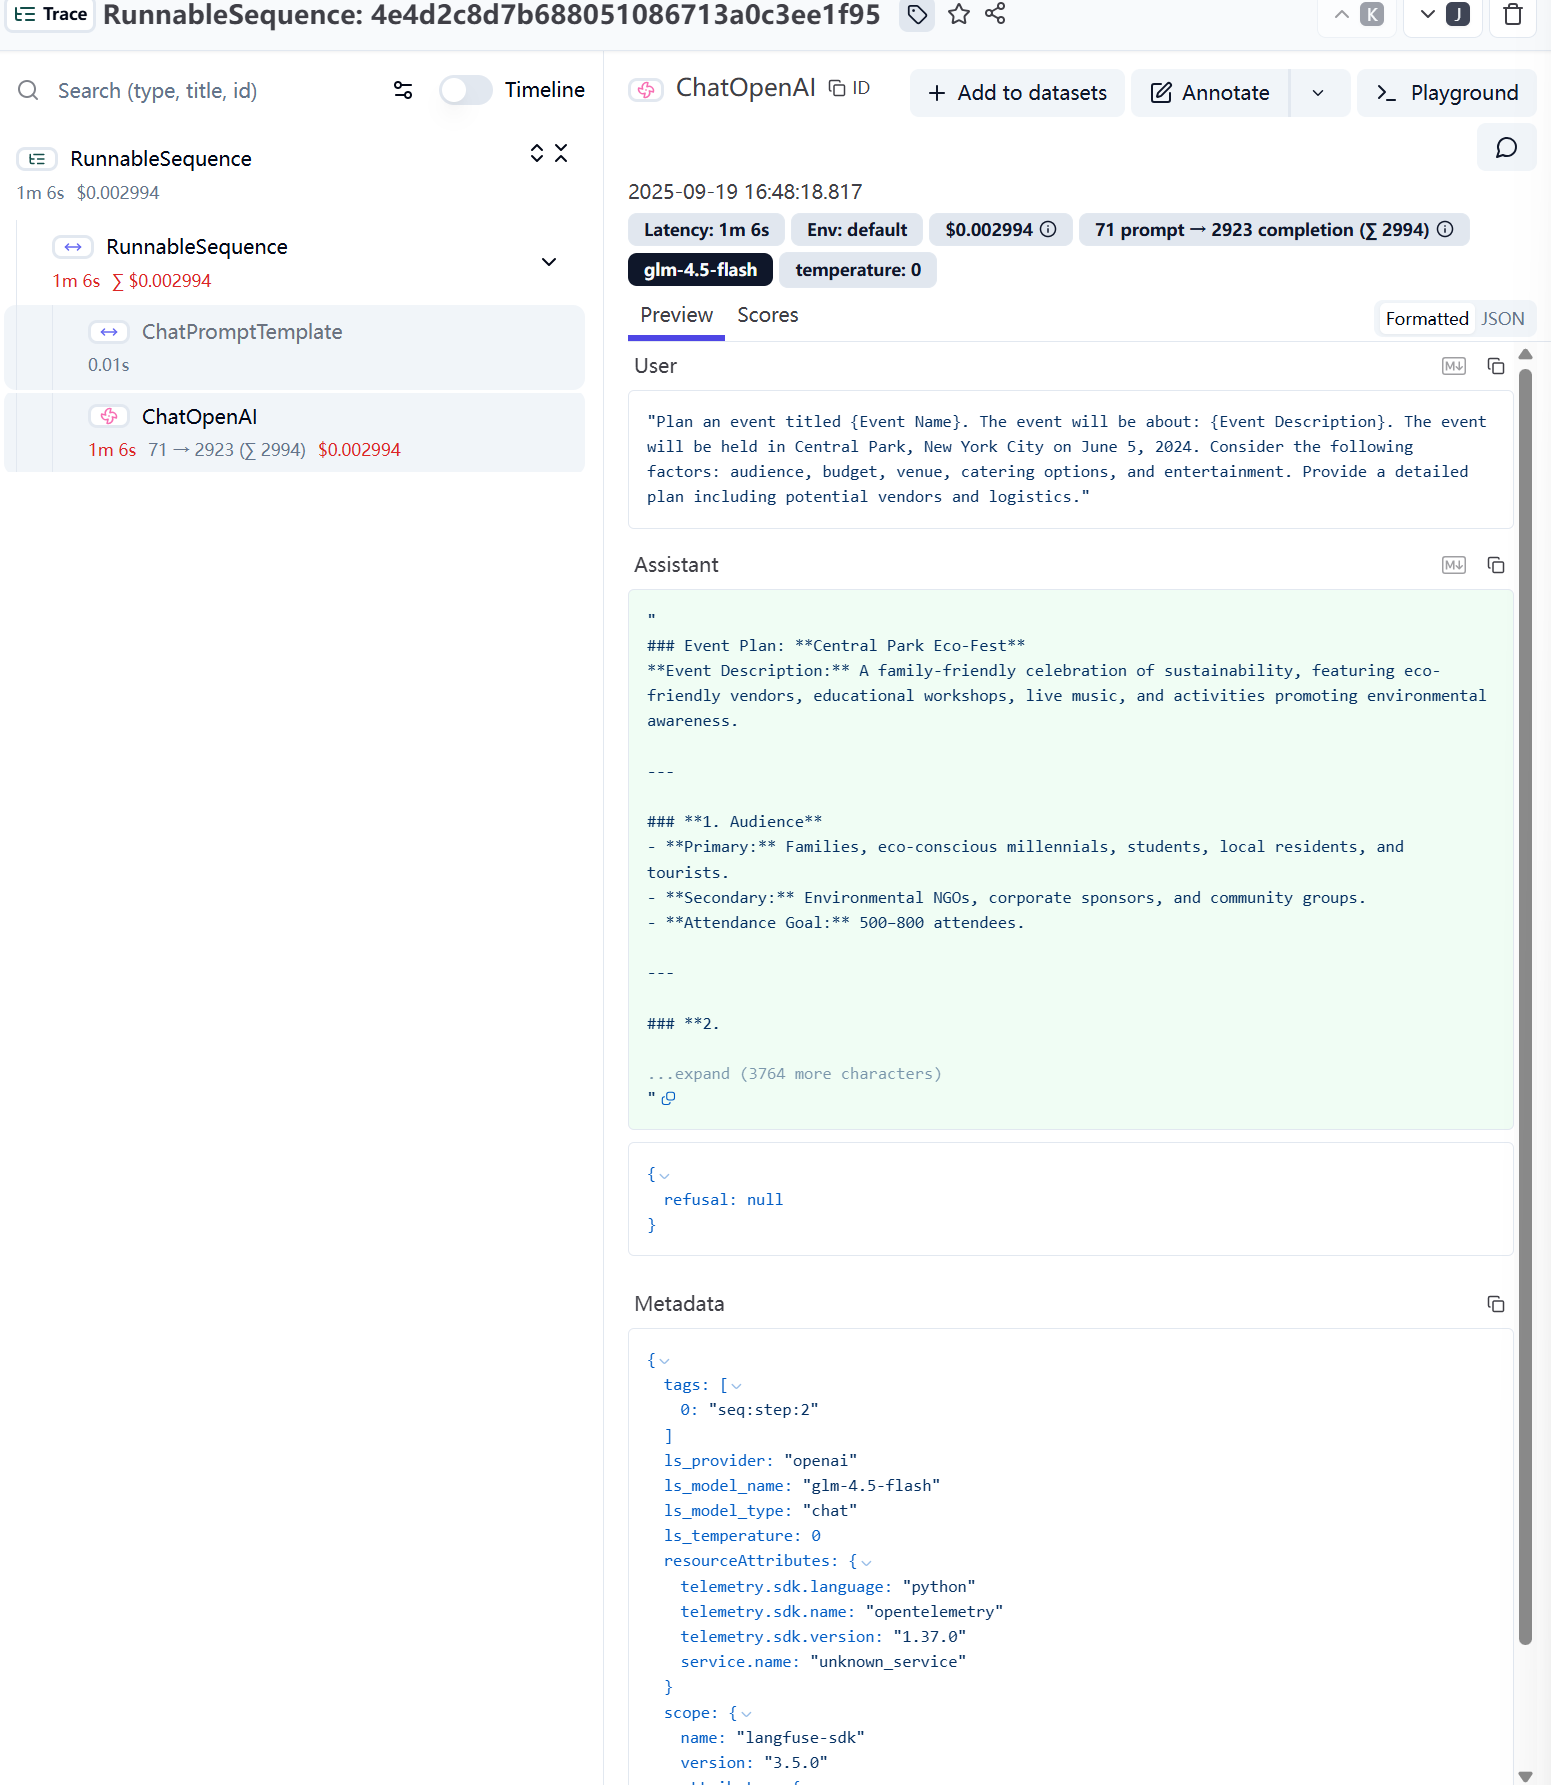